**Description**: Analyzes BERT *or* GPT-2 accuracies for a given number of test
observations (200 or 500).

**Estimated runtime**: ~1 hour (Multi-core isn't working on my machine. Set
`cores=4` in the `model.fit` call if it works for you.)

In [1]:
import os
from typing import Literal

import seaborn as sns

import utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_theme(style="darkgrid")

# Configuration

Which model and which number of test observations do you want to analyze?

In [3]:
model: Literal["bert", "gpt2"] = "gpt2"
num_test: Literal[200, 500] = 200

# Load data

In [4]:
accuracies_dir = os.path.join("accuracies_from_paper", str(num_test), model)
accuracy_df = utils.load_accuracies(accuracies_dir)
num_correct_df = utils.accuracies_to_num_correct(accuracy_df, num_test)

In [5]:
equation = "p(num_correct, num_test) ~ method + (1|dataset/pair)"

# Plot

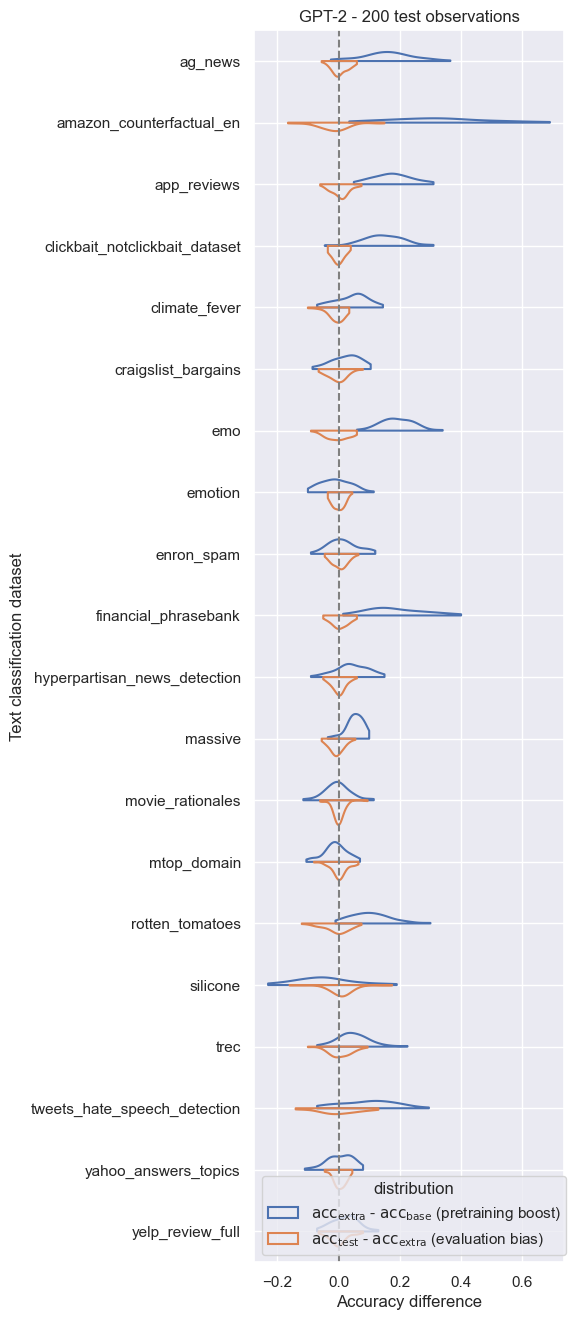

In [6]:
ax = utils.violin_plot(
    accuracy_df, title=f"{utils.lm_type_to_name[model]} - {num_test} test observations"
)
# sns.move_legend(
#     ax, "upper center",
#     bbox_to_anchor=(.1, 1), ncol=2, title=None, frameon=False,
# )  # not sure why this doesn't work

# Does pretraining help?

This is our control.

In [7]:
summary_control, summary_relative_control = utils.eda(
    accuracy_df, treatment="extra", control="base"
)

Overall difference:
┌──────────┬──────────┐
│ mean     ┆ se       │
╞══════════╪══════════╡
│ 0.078185 ┆ 0.020648 │
└──────────┴──────────┘
Overall difference (relative):
┌──────────┬──────────┐
│ mean     ┆ se       │
╞══════════╪══════════╡
│ 0.341779 ┆ 0.096467 │
└──────────┴──────────┘


In [8]:
summary_control

dataset,mean,se
"""ag_news""",0.1575,0.011742
"""amazon_counter…",0.3212,0.022447
"""app_reviews""",0.1751,0.009005
"""clickbait_notc…",0.1475,0.009169
"""climate_fever""",0.0431,0.007524
"""craigslist_bar…",0.0245,0.006689
"""emo""",0.1912,0.007568
"""emotion""",-0.0095,0.006832
"""enron_spam""",0.0154,0.006823
"""financial_phra…",0.1858,0.013321


In [9]:
summary_relative_control

dataset,mean,se
"""ag_news""",0.392494,0.037121
"""amazon_counter…",1.030442,0.14898
"""app_reviews""",1.561517,0.138976
"""clickbait_notc…",0.23892,0.01765
"""climate_fever""",0.220038,0.036467
"""craigslist_bar…",0.187543,0.044159
"""emo""",0.89294,0.051544
"""emotion""",-0.018055,0.037832
"""enron_spam""",0.025766,0.010432
"""financial_phra…",0.431695,0.04696


/Users/kdubey/Envs/pretrain/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, method, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 679 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[extra],0.404,0.007,0.39,0.417,0.0,0.0,2742.0,1389.0,1.0


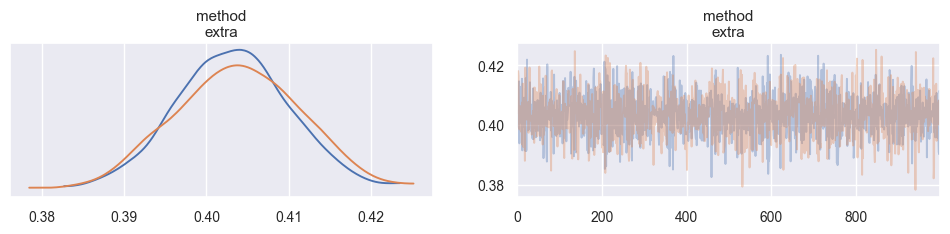

In [10]:
model_control, summary_control, az_summary_control = utils.stat_model(
    num_correct_df, treatment="extra", control="base", equation=equation, chains=2
)

In [11]:
print(model_control)

       Formula: p(num_correct, num_test) ~ method + (1|dataset/pair)
        Family: binomial
          Link: p = logit
  Observations: 2000
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            method ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|dataset ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            1|dataset:pair ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()


Solid evidence that pretraining helps. There's an effect to detect.

# Does pretraining on test cause bias?

In [12]:
summary_bias, summary_relative_bias = utils.eda(
    accuracy_df, treatment="test", control="extra"
)

Overall difference:
┌──────────┬──────────┐
│ mean     ┆ se       │
╞══════════╪══════════╡
│ 0.000735 ┆ 0.001316 │
└──────────┴──────────┘
Overall difference (relative):
┌──────────┬──────────┐
│ mean     ┆ se       │
╞══════════╪══════════╡
│ 0.007751 ┆ 0.004681 │
└──────────┴──────────┘


In [13]:
summary_bias

dataset,mean,se
"""ag_news""",0.006,0.003631
"""amazon_counter…",-0.0147,0.008274
"""app_reviews""",0.0067,0.004092
"""clickbait_notc…",-0.0005,0.002775
"""climate_fever""",-0.0066,0.003911
"""craigslist_bar…",-0.0038,0.004246
"""emo""",-0.0017,0.005048
"""emotion""",-0.0002,0.002653
"""enron_spam""",0.0046,0.003425
"""financial_phra…",0.0052,0.00393


In [14]:
summary_relative_bias

dataset,mean,se
"""ag_news""",0.011757,0.006276
"""amazon_counter…",-0.017358,0.012366
"""app_reviews""",0.024408,0.014251
"""clickbait_notc…",-0.000611,0.003485
"""climate_fever""",-0.018855,0.014744
"""craigslist_bar…",-0.003528,0.02333
"""emo""",0.000256,0.012414
"""emotion""",0.008815,0.014962
"""enron_spam""",0.007454,0.005027
"""financial_phra…",0.008667,0.005852


/Users/kdubey/Envs/pretrain/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, method, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 997 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[test],0.004,0.007,-0.011,0.016,0.0,0.0,4467.0,1308.0,1.0


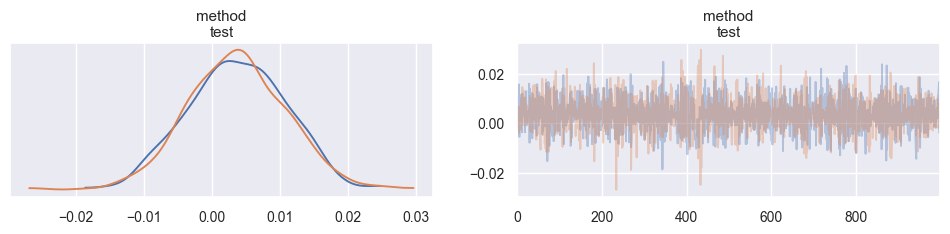

In [15]:
model_bias, summary_bias, az_summary_bias = utils.stat_model(
    num_correct_df, treatment="test", control="extra", equation=equation, chains=2
)

In [16]:
print(model_bias)

       Formula: p(num_correct, num_test) ~ method + (1|dataset/pair)
        Family: binomial
          Link: p = logit
  Observations: 2000
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            method ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|dataset ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            1|dataset:pair ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()
